In [29]:
library(ggplot2)
suppressPackageStartupMessages(library(extraDistr))
suppressPackageStartupMessages(library(distr))
suppressPackageStartupMessages(require(rstan))
library(tidyr) 
set.seed(2025)



Attaching package: 'tidyr'


The following object is masked from 'package:rstan':

    extract




### Q1: Installing and running Stan

In [2]:
# 1
#       mean se_mean   sd  2.5%   25%   50%   75% 97.5% n_eff Rhat
# p     0.81    0.01 0.16  0.40  0.73  0.85  0.93  0.99   765    1
# lp__ -3.07    0.03 0.76 -5.39 -3.28 -2.77 -2.56 -2.50   606    1

### Q2: Regression/classification in Stan

In [3]:
# 2
suppressPackageStartupMessages(require(ggplot2))
suppressPackageStartupMessages(require(dplyr))

df = read.csv(
  "https://raw.githubusercontent.com/UBC-Stat-ML/web447/1e345149a5b698ccdf0a7e9b0aeabec2463c50ca/data/sunspots-SN_m_tot_V2.0.csv",
  sep = ";", header=FALSE) %>%
  mutate(count = ceiling(V4)) %>%
  rename(year = V3) %>%
  filter(year > 2005)

counts = df$count 
time = df$year

In [4]:
init_fun <- function() {
  list(theta1 = 40, theta2 = 1.0, theta3 = 0.25)
}
fit = stan(seed=2025, file="./sunspots.stan", data=list(N=length(counts),y=counts), chains=1, iter=2500, init = init_fun)


SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000174 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 1.74 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2500 [  0%]  (Warmup)
Chain 1: Iteration:  250 / 2500 [ 10%]  (Warmup)
Chain 1: Iteration:  500 / 2500 [ 20%]  (Warmup)
Chain 1: Iteration:  750 / 2500 [ 30%]  (Warmup)
Chain 1: Iteration: 1000 / 2500 [ 40%]  (Warmup)
Chain 1: Iteration: 1250 / 2500 [ 50%]  (Warmup)
Chain 1: Iteration: 1251 / 2500 [ 50%]  (Sampling)
Chain 1: Iteration: 1500 / 2500 [ 60%]  (Sampling)
Chain 1: Iteration: 1750 / 2500 [ 70%]  (Sampling)
Chain 1: Iteration: 2000 / 2500 [ 80%]  (Sampling)
Chain 1: Iteration: 2250 / 2500 [ 90%]  (Sampling)
Chain 1: Iteration: 2500 / 2500 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 3.849 seconds (Warm-up)
Chain 1:                2.06 seconds (Sampling)
Chain 1:                5.90

In [20]:
samples = extract(fit)
theta1_samples = samples$theta1
theta2_samples = samples$theta2
theta3_samples = samples$theta3
theta_samples = data.frame(theta1 = theta1_samples, theta2 = theta2_samples, theta3 = theta3_samples)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


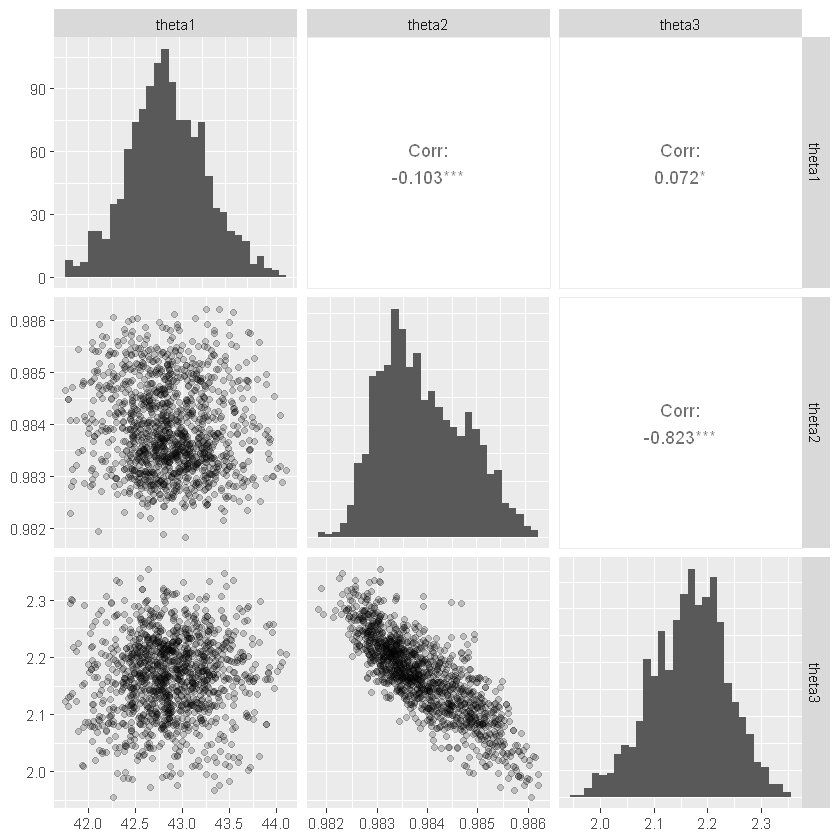

In [ ]:
library(GGally)
library(ggplot2)

ggpairs(theta_samples, 
        lower = list(continuous = wrap("points", alpha = 0.2)),
        diag = list(continuous = "barDiag"),
        upper = list(continuous = "cor"),
)

### Q3: A simple MCMC algorithm

In [141]:
#3
# prior: Beta(alpha, beta)
alpha = 1
beta = 2 

# observations: binomial draws
n_successes = 3 
n_trials = 3

gamma_beta_binomial = function(p) {
    if (p < 0 || p > 1) {
        return(0.0)
    }
    dbeta(p, alpha, beta) * dbinom(x = n_successes, size = n_trials, prob = p)
}

# simple Metropolis-Hastings algorithm (normal proposal)
simple_mh = function(gam, initial_point, n_iters) {
  samples = numeric(n_iters) 
  dim = length(initial_point)
  curr = initial_point
  for (i in 1:n_iters) {
    proposed = rnorm(1, curr, 1)
    if (proposed < 0 || proposed > 1) {
      samples[i] = curr
    }
    else {
      accept_prob = min(1, gamma(proposed)/gamma(curr))
      u = runif(1, 0, 1)
      if (u < accept_prob) {
        samples[i] = proposed
        curr = proposed
      }
      else {
        samples[i] = curr
      }
    }
    
  }
  return(samples)
}

In [147]:
samples = simple_mh(gamma_beta_binomial, 0.2, 1500)

In [148]:
mean(samples)
median(samples)

[1] 0.09808845

[1] 0.006785577